# Build CNN with TF-Slim

In [1]:
import tensorflow as tf
import mnist
mn = mnist.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mn.train.images, mn.train.labels, mn.test.images, mn.test.labels

('Extracting', 'MNIST_data/train-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/train-labels-idx1-ubyte.gz')
('Extracting', 'MNIST_data/t10k-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/t10k-labels-idx1-ubyte.gz')


/usr/local/lib/python2.7.12/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
mnist.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
rcParams['font.size'] = 20
plt.style.use('ggplot')
#plt.imshow(np.array(trX[0]*256, dtype=np.uint8).reshape((28, 28)), cmap='gray')

In [3]:
import tensorflow.contrib.slim as slim

In [4]:
X = tf.placeholder("float", [None, 784])
Y = tf.placeholder("float", [None, 10])
is_training = tf.placeholder("bool")
net = tf.reshape(X, [-1, 28, 28, 1])

## `slim.conv2d`

* `inputs`: 輸入tensor
* `num_outputs`: 輸出的channel數量
* `kernel_size`: kernel的大小
* `stride=1`
* `padding='SAME'`
* `rate=1`: atrous convolution 的間隔
* `activation_fn=nn.relu`
* `weights_initializer=initializers.xavier_initializer()`
* `biases_initializer=init_ops.zeros_initializer`

In [5]:
with tf.device('/gpu:0'):
    with slim.arg_scope([slim.conv2d], weights_regularizer=slim.l2_regularizer(0.0005)):
        net = slim.conv2d(net, 32, [3, 3], scope='conv1_1')  # 28x28x32
        net = slim.max_pool2d(net, [2, 2], scope='pool1')    # 14x14x32
        net = slim.conv2d(net, 64, [3, 3], scope='conv2_1')  # 14x14x64
        net = slim.max_pool2d(net, [2, 2], scope='pool1')    # 7x7x64
        net = slim.conv2d(net, 128, [3, 3], scope='conv3_1') # 7x7x128
        net = slim.max_pool2d(net, [2, 2], scope='pool1')    # 3x3x128
        net = slim.conv2d(net, 2048, [3, 3], padding='VALID', scope='fc1')    # 1x1x2048
        net = slim.dropout(net, 0.5, is_training=is_training, scope='dp1')
        net = slim.conv2d(net, 625, [1, 1], scope='fc2')   # 1x1x625
        net = slim.dropout(net, 0.8, is_training=is_training, scope='dp2')
        net = slim.conv2d(net, 10, [1, 1], activation_fn=None, scope='pre')   # 1x1x10
        logits = tf.squeeze(net, [1, 2], name='logits')      # 10
        reg_loss = tf.add_n(slim.losses.get_regularization_losses())
        ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, Y))
        cost = reg_loss + ce_loss
        predict_op = tf.argmax(logits, 1)

0 0.9698
1 0.9837
2 0.9873
3 0.9872
4 0.9878
5 0.9887
6 0.9885
7 0.9901
8 0.9893
9 0.9903


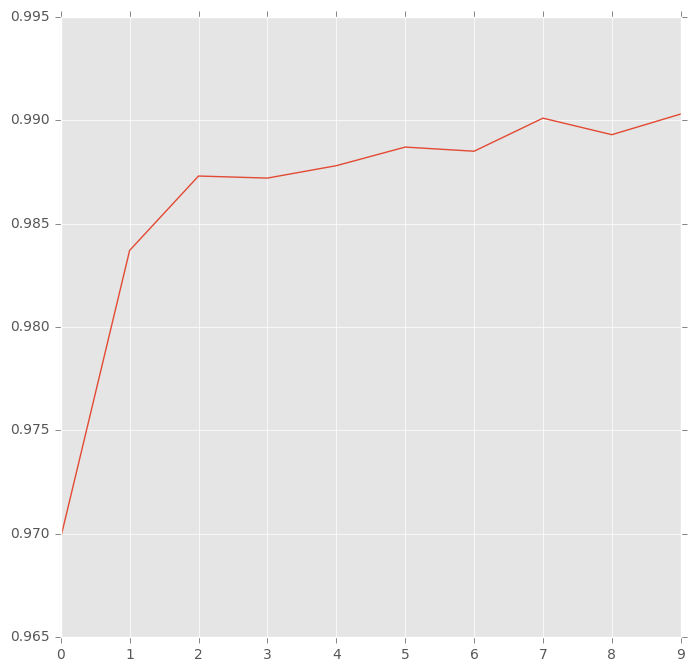

In [7]:
train_op = tf.train.RMSPropOptimizer(0.0005, 0.9).minimize(cost)

with tf.Session() as sess:
    accu = []
    tf.global_variables_initializer().run()
    batch_size = 128

    for i in range(10):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end], is_training: True})

        y = sess.run(predict_op, feed_dict={X: teX, Y: teY, is_training: False})
        accu.append(np.mean(np.argmax(teY, axis=1) == y))
        print i, accu[-1]

plt.plot(accu)